In [1]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import matplotlib.pyplot as plt
from scipy.linalg import svd

### **Hamiltonian System Overview**

This section simulates a two-chain spin system interacting with an external magnetic field. The system is composed of two distinct spin chains and a central witness spin. By constructing and analyzing the Hamiltonian for this system, we can explore its quantum behavior under different interactions and external fields.

The system consists of:

- **Chain 1**: Contains $N_1$ spins.
- **Chain 2**: Contains $N_2$ spins.
- **Central Witness Spin**: Denoted as $\sigma_0$, this spin interacts with both chains.

### **Hamiltonian Definition**

The Hamiltonian $\mathbf{H}$ governs the system’s evolution. It is defined as:


\begin{aligned}
\mathbf{H} = & - g_1 \mu_B H \sum_{n=1}^{N_1} S_{1,n}^z 
& - g_2 \mu_B H \sum_{n=1}^{N_2} S_{2,n}^z 
& - g_0 \mu_B H \sigma_0^z 
 - J_1 \sum_{n=1}^{N_1 - 1} \left( S_{1,n}^x S_{1,n+1}^x + S_{1,n}^y S_{1,n+1}^y \right) 
& - J_2 \sum_{n=1}^{N_2 - 1} \left( S_{2,n}^x S_{2,n+1}^x + S_{2,n}^y S_{2,n+1}^y \right) 
& - J_0 \sigma_0^z \left( S_{1,N_1}^z + S_{2,1}^z + S_{2,N_2}^z \right).
\end{aligned}

This Hamiltonian includes the following key components:

- **Zeeman Terms**: The first three terms represent the interaction of the spins with the external magnetic field $H$. Each spin in Chain 1, Chain 2, and the witness spin $\sigma_0$ is affected by this field. The coupling constants $g_1$, $g_2$, and $g_0$ modulate the strength of the interaction with the field for the respective spins.
  
- **Interaction Terms Within Chains**: The fourth and fifth terms represent nearest-neighbor interactions within Chain 1 and Chain 2. The Pauli-X ($S_x$) and Pauli-Y ($S_y$) operators describe the spin-spin couplings, which determine how spins in the same chain influence each other.

- **Interaction with Central Spin**: The final term describes the interaction between the central witness spin $\sigma_0$ and the spins at the ends of Chain 1 and Chain 2. This coupling is governed by the constant $J_0$ and contributes to how the central spin interacts with its neighbors.

---

### **System Visualization**

To better understand the structure, you can visualize the system as follows:

- **Chain 1**: A line of $N_1$ spins, each interacting with its nearest neighbor.
- **Chain 2**: Another line of $N_2$ spins, also interacting with nearest neighbors.
- **Central Witness Spin**: A single spin $\sigma_0$ placed between Chain 1 and Chain 2, interacting with both chains.

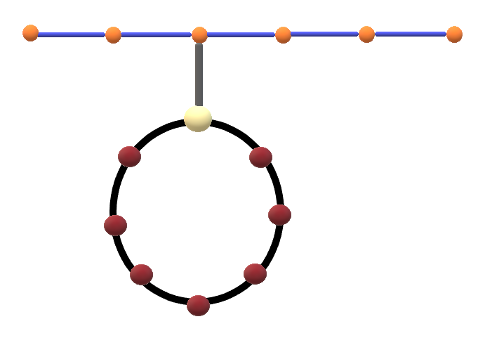
<!-- ![Alt text](path_to_your_image.png) -->
<!-- Optionally include a system diagram here. -->

### **Pauli Matrices and System Parameters**

The system's dynamics are defined using the Pauli matrices, which describe the quantum states of spins. Additionally, key physical parameters govern the interactions and external influences on the system:

#### **Pauli Matrices**:
- $S_x$: Pauli-X matrix, representing spin-flip operations.
- $S_y$: Pauli-Y matrix, representing phase-flip operations.
- $S_z$: Pauli-Z matrix, representing spin alignment along the $z$-axis.
- **Identity**: The $2 \times 2$ identity matrix ($I_2$) used for constructing multi-spin operators.

#### **System Parameters**:
- **$N_1, N_2$**: Number of spins in Chain 1 and Chain 2, respectively.
- **$g_1, g_2, g_0$**: Coupling constants governing the interaction between the spins and the external magnetic field for Chain 1, Chain 2, and the central witness spin.
- **$\mu_B$**: Bohr magneton, which sets the scale for the magnetic interactions.
- **$H_{\text{field}}$**: Strength of the external magnetic field applied to the system.
- **$J_1, J_2, J_0$**: Spin coupling constants that control the strength of the interactions within Chain 1, Chain 2, and between the central witness spin and its neighbors.

The total number of spins in the system is:

$$ N = N_1 + N_2 + 1 $$

The additional $1$ represents the central witness spin $\sigma_0$. This definition ensures the Hamiltonian acts on the entire system of spins.



In [15]:
def initialize_system():
    """Initialize system parameters and Pauli matrices."""
    global sx, sy, sz, identity
    global N1, N2, g1, g2, g0, muB, H_field, J1, J2, J0, N
    
    # Pauli matrices
    sx = np.array([[0, 1], [1, 0]], dtype=complex)
    sy = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sz = np.array([[1, 0], [0, -1]], dtype=complex)
    identity = np.eye(2, dtype=complex)

    # System parameters
    N1 = 5  # Number of spins in the first chain
    N2 = 4  # Number of spins in the second chain
    g1, g2, g0 = 1.0, 1.0, 1.0  # Coupling constants
    muB = 1.0  # Bohr magneton
    H_field = 1.0  # External magnetic field
    J1, J2, J0 = 1.0, 1.0, 1.0  # Spin coupling constants

    # Total number of spins (sigma_0 + chain 1 + chain 2)
    N = N1 + N2 + 1  # +1 for sigma_0

initialize_system()


# Kronecker Product Function
The `kron_n` function is used to efficiently construct large operators that act on the entire spin system. By using the Kronecker product of single-site operators, we can apply various operations (like external fields or spin interactions) to the whole system. This step is crucial for the scalability of the simulation, as manually constructing these large matrices would be inefficient and error-prone.

The sparse matrix format is used to save memory and ensure faster computation in large systems, making this approach efficient for quantum many-body problems.


In [3]:
def kron_n(op_list):
    """Create a Kronecker product of a list of operators."""
    result = op_list[0]
    for op in op_list[1:]:
        result = sp.kron(result, op, format='csr')
    return result


### **Building the Hamiltonian**

This function constructs the full Hamiltonian for our two-chain spin system interacting with an external magnetic field. The Hamiltonian governs the dynamics and evolution of the system by describing both the external field influence on the spins and the interactions between them.

The process is broken down into several key steps:

1. **Hilbert Space Setup**:  
   We begin by determining the dimension of the Hilbert space, which is $2^N$, where $N$ is the total number of spins in the system (the spins from Chain 1, Chain 2, and the witness spin $\sigma_0$). The Hamiltonian matrix is initialized as a sparse matrix to efficiently handle its potentially large size.

2. **External Field Terms**:  
   The external magnetic field interacts with each spin in the system, contributing to the overall energy. This is calculated separately for:
   - The central witness spin $\sigma_0$.
   - Each spin in Chain 1 and Chain 2.

3. **Interaction Terms within Chains**:  
   The spins in each chain interact with their nearest neighbors via Pauli-X ($S_x$) and Pauli-Y ($S_y$) operators. This step describes the spin-spin interactions within each chain, which are essential for capturing the system's internal dynamics.

4. **Interaction Between Witness Spin and Chains**:  
   The witness spin $\sigma_0$ interacts with a specified spin in Chain 1, as well as the first and last spins of Chain 2. This cross-chain interaction helps model how the two chains communicate through the witness spin.

5. **Periodic Boundary Conditions**:  
   For Chain 2, periodic boundary conditions are implemented, meaning that the first and last spins are also considered neighbors, closing the loop of interactions within Chain 2.

Each step adds a piece of the total Hamiltonian matrix. The function is structured to be flexible and modular, allowing the system's parameters (such as coupling constants or the external field) to be easily adjusted for different physical scenarios.

By building the Hamiltonian in this piecewise manner, we capture both local and long-range interactions, making it a comprehensive model for studying the quantum behavior of this spin system.

In [4]:
def build_hamiltonian(verbose=False, connected_spin_index=2):
    """Build the Hamiltonian for the system."""
    if verbose:
        print("Building Hamiltonian...")
    D = 2**N  # Dimension of the Hilbert space
    if verbose:
        print(f"Total number of spins N = {N}, Hilbert space dimension D = {D}")
    
    # Initialize Hamiltonian
    H_total = sp.csr_matrix((D, D), dtype=complex)
    
    # External field term for sigma_0 (witness spin)
    if verbose:
        print("Adding external field term for witness spin...")
    op_list = [identity]*N
    op_list[N1] = sz  # Witness spin is at index N1
    sigma0_z = kron_n(op_list)
    H_sigma0 = -g0 * muB * H_field * sigma0_z
    H_total += H_sigma0
    
    # External field terms for Chain 1
    if verbose:
        print("Adding external field terms for Chain 1...")
    for i in range(N1):
        op_list = [identity]*N
        op_list[i] = sz
        term = -g1 * muB * H_field * kron_n(op_list)
        H_total += term
    
    # External field terms for Chain 2
    if verbose:
        print("Adding external field terms for Chain 2...")
    for i in range(N2):
        op_list = [identity]*N
        op_list[N1 + 1 + i] = sz  # Chain 2 starts after sigma_0
        term = -g2 * muB * H_field * kron_n(op_list)
        H_total += term
    
    # Interaction terms within Chain 1
    if verbose:
        print("Adding interaction terms within Chain 1...")
    for i in range(N1 - 1):
        for op in [sx, sy]:
            op_list = [identity]*N
            op_list[i] = op
            op_list[i+1] = op
            H_total += -J1 * kron_n(op_list)
    
    # Interaction between witness spin and specified spin in Chain 1
    if verbose:
        print("Adding interaction between witness spin and specified spin in Chain 1...")
    witness_spin_index = N1  # Witness spin index
    op_list = [identity]*N
    op_list[witness_spin_index] = sz
    op_list[connected_spin_index] = sz  # Connected spin in Chain 1
    H_total += -J0 * kron_n(op_list)
    
    # Interaction terms within Chain 2 with periodic boundary conditions
    if verbose:
        print("Adding interaction terms within Chain 2 (circular)...")
    for i in range(N2):
        idx1 = N1 + 1 + i % N2
        idx2 = N1 + 1 + (i + 1) % N2
        for op in [sx, sy]:
            op_list = [identity]*N
            op_list[idx1] = op
            op_list[idx2] = op
            H_total += -J2 * kron_n(op_list)
    
    # Interaction between witness spin and Chain 2 spins
    if verbose:
        print("Adding interaction between witness spin and Chain 2 spins...")
    # Witness spin interacts with first and last spins of Chain 2
    for idx in [N1 + 1, N1 + N2]:
        op_list = [identity]*N
        op_list[witness_spin_index] = sz
        op_list[idx] = sz
        H_total += -J0 * kron_n(op_list)
    
    if verbose:
        print("Hamiltonian construction completed.")
    return H_total


# Diagonalizing the Hamiltonian
Once the Hamiltonian is built, the next step is to diagonalize it. Diagonalization allows us to find the eigenvalues and eigenvectors, which correspond to the energy levels and quantum states of the system. The function uses an efficient sparse diagonalization routine to handle the large matrix size.

The eigenvalues provide insight into the system's energy spectrum, while the eigenvectors are the quantum states that we will analyze further. This step is computationally intensive but is essential for understanding the system's quantum properties.


In [5]:
def diagonalize_hamiltonian(H):
    """Diagonalize the Hamiltonian and return eigenvalues and eigenvectors."""
    print("Diagonalizing Hamiltonian...")
    eigenvalues, eigenvectors = spla.eigsh(H, k=10, which='SA')
    return eigenvalues, eigenvectors

# Main Execution and Initial Results
In this section, we bring everything together by initializing the system, constructing the Hamiltonian, and then diagonalizing it to obtain the energy levels. The system's energy spectrum tells us about its possible quantum states and helps identify degenerate states, which are important for understanding symmetry and phase transitions.

The identification of degenerate eigenstates is crucial, as it can indicate hidden symmetries or critical points in the system, especially when tuning parameters like the external magnetic field.


In [8]:
# MAIN FLOW
initialize_system()

# Build the Hamiltonian and explore eigenstates
H = build_hamiltonian(verbose=False, connected_spin_index=2)

# Diagonalize Hamiltonian to find ground state and explore degeneracy
eigenvalues, eigenvectors = diagonalize_hamiltonian(H)

# Output energy levels
print("Energy levels:")
for idx, energy in enumerate(eigenvalues):
    print(f"Level {idx+1}: {energy}")

# Check for degeneracies
degenerate_pairs = []
for i in range(len(eigenvalues)-1):
    if np.isclose(eigenvalues[i], eigenvalues[i+1], atol=1e-6):
        degenerate_pairs.append((i, i+1))

if degenerate_pairs:
    print(f"Degenerate eigenstates found between the following eigenvalue indices:")
    for pair in degenerate_pairs:
        print(f"Eigenvalue {pair[0]+1} and Eigenvalue {pair[1]+1} are degenerate.")
else:
    print("No degenerate eigenstates found within the tolerance.")


Diagonalizing Hamiltonian...
Energy levels:
Level 1: -15.19845658568398
Level 2: -15.198456585684037
Level 3: -13.962388608184153
Level 4: -13.804007861147992
Level 5: -14.236067977499978
Level 6: -14.236067977499983
Level 7: -13.962388608184096
Level 8: -13.804007861147948
Level 9: -13.000000000000146
Level 10: -13.00000000000009
Degenerate eigenstates found between the following eigenvalue indices:
Eigenvalue 1 and Eigenvalue 2 are degenerate.
Eigenvalue 5 and Eigenvalue 6 are degenerate.
Eigenvalue 9 and Eigenvalue 10 are degenerate.


# Symmetry Analysis of Eigenstates
After obtaining the eigenstates from diagonalization, we analyze their parity symmetry. Parity symmetry reveals how the system behaves under spatial inversion (flipping the spins). Eigenstates with strong parity symmetry may indicate that the system is invariant under certain transformations, which can lead to deeper insights into its quantum properties.

Symmetry breaking is a hallmark of phase transitions, and tracking symmetry helps us detect such phenomena.

In [7]:
def check_parity_symmetry(eigenvector):
    """Check the parity symmetry of an eigenvector."""
    reflection_operator = kron_n([np.fliplr(identity) for _ in range(N)])
    reflected_vector = reflection_operator @ eigenvector
    symmetry_value = np.vdot(eigenvector, reflected_vector)
    return symmetry_value

# Analyze symmetry of eigenstates
print("Checking parity symmetry of the eigenstates...")
for idx in range(len(eigenvalues)):
    symmetry_value = check_parity_symmetry(eigenvectors[:, idx])
    print(f"Eigenstate {idx+1} has parity symmetry value: {symmetry_value}")


Checking parity symmetry of the eigenstates...
Eigenstate 1 has parity symmetry value: (-8.556369081441012e-17+2.465190328815662e-32j)
Eigenstate 2 has parity symmetry value: (3.78480936142545e-17+6.162975822039155e-33j)
Eigenstate 3 has parity symmetry value: (-1.1912734720291176e-18-3.0814879110195774e-33j)
Eigenstate 4 has parity symmetry value: (1.1828590461582518e-16+1.5407439555097887e-33j)
Eigenstate 5 has parity symmetry value: (1.0851701727865955e-18-3.0814879110195774e-33j)
Eigenstate 6 has parity symmetry value: (-7.469828236378576e-18+1.925929944387236e-33j)
Eigenstate 7 has parity symmetry value: (-1.2778978987863547e-17+7.703719777548943e-34j)
Eigenstate 8 has parity symmetry value: (-5.853963606021953e-18-1.7333369499485123e-33j)
Eigenstate 9 has parity symmetry value: (9.402213737647193e-19+3.0814879110195774e-33j)
Eigenstate 10 has parity symmetry value: (-2.830242676285015e-19+3.611118645726067e-35j)


# Plotting the Energy Spectrum
Visualizing the energy spectrum gives a clear picture of the system's quantum state distribution. By plotting the eigenvalues, we can easily identify gaps in the spectrum (important for understanding quantum phase transitions) and see how the energy levels are distributed.

Energy gaps, especially between the ground state and excited states, can give insight into the stability of the system and whether it is in a critical phase.


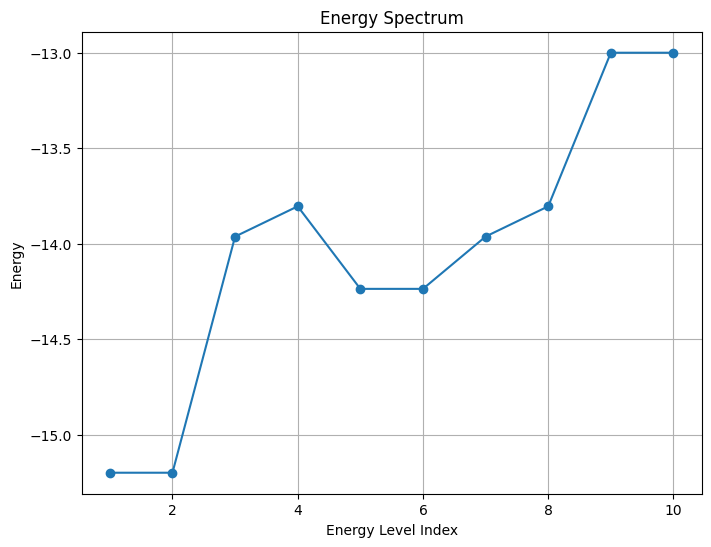

In [9]:
def plot_energy_spectrum(eigenvalues):
    """Plot the energy spectrum."""
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-')
    plt.xlabel('Energy Level Index')
    plt.ylabel('Energy')
    plt.title('Energy Spectrum')
    plt.grid(True)
    plt.show()

# Plot the energy spectrum
plot_energy_spectrum(eigenvalues)


# Calculating and Plotting Magnetization
The magnetization ⟨Sᶻ⟩ measures how much each spin aligns with the external magnetic field. By calculating this for each spin in the ground state, we can understand how the external field affects the system at a microscopic level. This is especially important for detecting ordered phases (like ferromagnetism) and understanding how individual spins behave under different conditions.

By plotting the magnetization for each spin, we can easily visualize how the chains respond to the external field and spin-spin interactions.


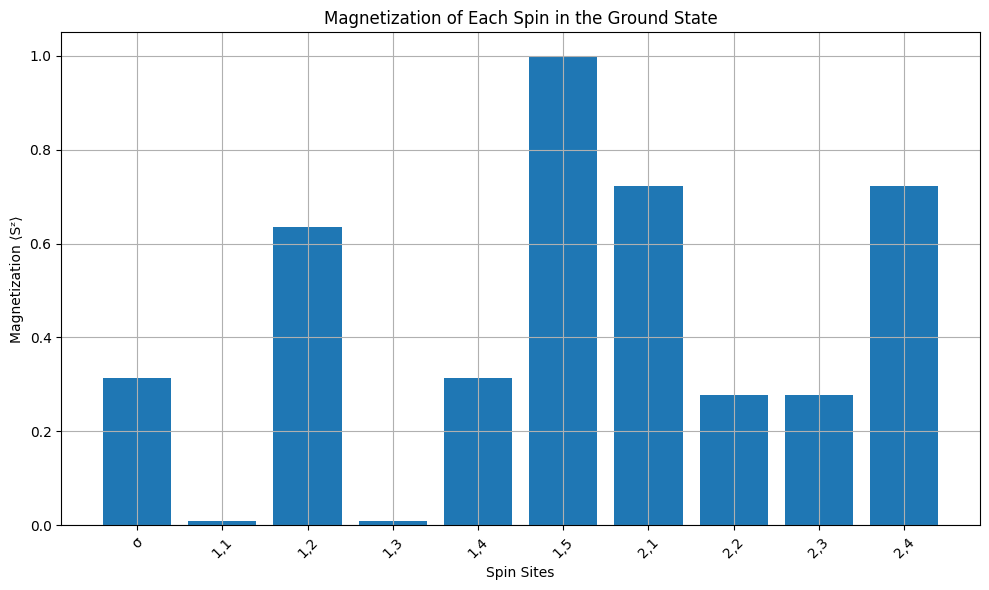

In [16]:
def compute_magnetization(ground_state):
    """Compute the magnetization for each spin in the system."""
    magnetizations = []
    for site in range(N):
        if site == 0:
            # sigma_0
            op_list = [sz] + [identity]*(N - 1)
        elif 1 <= site <= N1:
            # Chain 1 spins
            op_list = [identity] + [identity]*(site - 1) + [sz] + [identity]*(N - site - 1)
        else:
            # Chain 2 spins
            idx = site - N1
            op_list = [identity] + [identity]*N1 + [identity]*(idx - 1) + [sz] + [identity]*(N2 - idx)
        S_z = kron_n(op_list)
        mag = np.vdot(ground_state, S_z.dot(ground_state)).real
        magnetizations.append(mag)
    return magnetizations

# Compute the magnetization
ground_state = eigenvectors[:, 0]  # The ground state is the first eigenvector
magnetizations = compute_magnetization(ground_state)

def plot_magnetization(magnetizations):
    """Plot the magnetization of each spin."""
    spin_labels = ['σ'] + [f'1,{i+1}' for i in range(N1)] + [f'2,{i+1}' for i in range(N2)]
    plt.figure(figsize=(10, 6))
    plt.bar(spin_labels, magnetizations)
    plt.xlabel('Spin Sites')
    plt.ylabel('Magnetization ⟨Sᶻ⟩')
    plt.title('Magnetization of Each Spin in the Ground State')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot the magnetization
plot_magnetization(magnetizations)

# Spin-Spin Correlation
The spin-spin correlation function ⟨Sᶻᵢ Sᶻⱼ⟩ measures how the magnetic moment of one spin is related to another at different positions. This helps in understanding long-range correlations, which are essential for detecting quantum phase transitions and the presence of entanglement in the system.

Strong correlations between distant spins may indicate quantum coherence or the presence of an ordered phase, making this an essential tool for analyzing many-body quantum systems.


Computing spin-spin correlation functions...


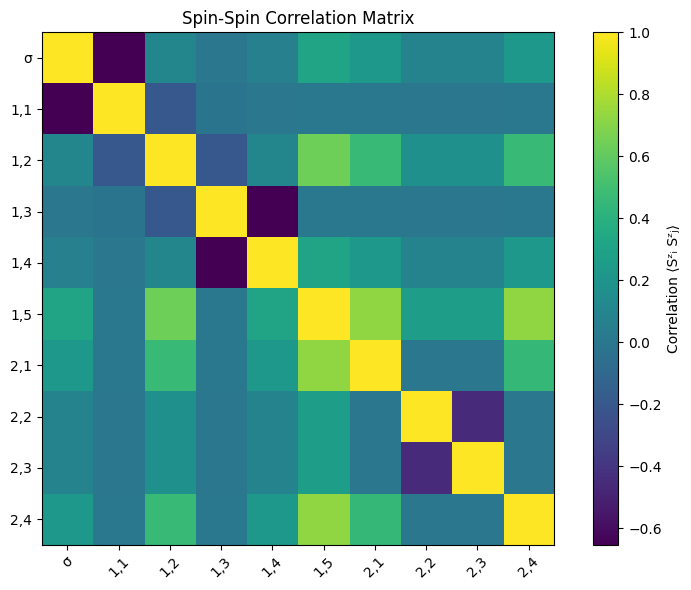

In [17]:
def compute_spin_spin_correlation(ground_state):
    """Compute the spin-spin correlation matrix for the system."""
    print("Computing spin-spin correlation functions...")
    
    spin_indices = range(N)  # All spins
    correlations = np.zeros((N, N))

    for i in spin_indices:
        for j in spin_indices:
            op_list_i = [identity]*N
            op_list_i[i] = sz
            S_i_z = kron_n(op_list_i)
            
            op_list_j = [identity]*N
            op_list_j[j] = sz
            S_j_z = kron_n(op_list_j)
            
            # Compute the correlation
            correlation_op = S_i_z.dot(S_j_z)
            corr = np.vdot(ground_state, correlation_op.dot(ground_state)).real
            correlations[i, j] = corr

    # Plot correlation matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(correlations, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Correlation ⟨Sᶻᵢ Sᶻⱼ⟩')
    spin_labels = ['σ'] + [f'1,{i+1}' for i in range(N1)] + [f'2,{i+1}' for i in range(N2)]
    plt.xticks(range(N), spin_labels, rotation=45)
    plt.yticks(range(N), spin_labels)
    plt.title('Spin-Spin Correlation Matrix')
    plt.tight_layout()
    plt.show()

    return correlations

# Call the function to compute the spin-spin correlations
correlations = compute_spin_spin_correlation(ground_state)